In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, concatenate
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [2]:
#doses pulled from Data Analysis/CLOCK_DATA/ACLK Graph to match LPM0,2,4 on first 11 trials - maybe automate this later
doses = np.array([ 0.  ,  5.44, 10.88, 16.32, 21.76, 27.2 , 32.64, 38.08, 43.52,
       48.96, 54.4,  0.  ,  5.44, 10.88, 16.32, 21.76, 27.2 ,
       32.64, 38.08, 43.52, 48.96, 54.4,  0.  ,  5.44, 10.88,
       16.32, 21.76, 27.2 , 32.64, 38.08, 43.52, 48.96, 54.4])
classes = ["0-16.32", "16.32-43.52", "43.52+"]

In [3]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

Average observed period
- Calc each period time
- Loop through points, recording initial raise point, and fall point
- Period will be one for top portion and one for bottom portion all merged into one list

In [4]:
test = pd.read_csv(f"/Users/trevorpeyton/Downloads/Channel1/LPM2_Trial11.csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()

In [5]:
import itertools

In [6]:
def calc_jitter(data, target):
    delta = np.array([y-x for x, y in zip(data, data[1:])])
    delta_global = delta - delta.mean()
    delta_local = np.array([y-x for x, y in zip(delta, delta[1:])])
    delta_global = np.array(list(itertools.chain(*(itertools.repeat(elem, n) for elem, n in zip(delta_global, delta)))))
    delta_local = np.array(list(itertools.chain(*(itertools.repeat(elem, n) for elem, n in zip(delta_local, delta)))))
    delta = np.array(list(itertools.chain(*(itertools.repeat(elem, n) for elem, n in zip(delta, delta)))))
    #return delta, delta_global, delta_local
    return (np.pad(delta, (target - len(delta), 0), 'constant'),
         np.pad(delta_global, (target - len(delta_global), 0), 'constant'),
         np.pad(delta_local, (target - len(delta_local), 0), 'constant'))


#Testing jitter measurements

# print(f"trail, rising time steps, falling time steps, rising avg diff, falling avg diff, rising local diff, falling local diff")
# for x in ["0", "2", "4-1"]:
#     for i in range(11):
#         test = pd.read_csv(f"/Users/trevorpeyton/Downloads/Channel1/LPM{x}_Trial{i}.csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()
        
#         rise_fall_times = []
#         current, prev = test[0], test[0]
#         first_rise = False #keep track of first rise so we don't mix up rising/falling data
#         for n, val in enumerate(test):
#             prev, current = current, val
#             rising = prev > 1.5 and current < 1.5
#             falling = prev < 1.5 and current > 1.5
#             if rising or falling:
#                 rise_fall_times.append(n)
        
#         cycles_first = rise_fall_times[::2] #first edge (rising/falling)
#         cycles_second = rise_fall_times[1::2] #second edge (rising/falling)
        
#         rising_delta, rising_delta_global, rising_delta_local = calc_jitter(cycles_first, test.shape[0])
#         falling_delta, falling_delta_global, falling_delta_local = calc_jitter(cycles_second, test.shape[0])
        
        #print(f"LPM{x}_Trail{i} {rising_delta.mean()} {falling_delta.mean()} {rising_delta_global.mean()} {falling_delta_global.mean()} {rising_delta_local.mean()} {falling_delta_local.mean()}")
    #print()

In [11]:
#load data
trial_path = "/Users/trevorpeyton/Downloads/"
trial_numbers = np.arange(11)
channels = ["Channel1"]
modes = ["LPM0", "LPM2", "LPM4-1"]
trial_labels = [(f"{channel}/{mode}_Trial{number}", mode) for mode in modes for number in trial_numbers for channel in channels] #modified to pass along mode
trials = [(pd.read_csv(trial_path + label + ".csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy(), mode) for label, mode in trial_labels] #(data, mode)

trial_slide_width = 2000
test_percent = .3
val_percent = .3 #percent of test set to be reserved for validation


#temp_df = {"raw": [], "rise_delta": [], "rise_global": [], "rise_local": [], "fall_delta": [], "fall_global": [], "fall_local": [], "class": [], "mode": []}
temp_df = {"raw": [], "class": [], "mode": []}

for i, (trial, mode) in enumerate(trials):
    #jitter measurements for data
    # rise_fall_times = []
    # current, prev = trial[0], trial[0]
    # first_rise = False #keep track of first rise so we don't mix up rising/falling data
    # for n, val in enumerate(trial):
    #     prev, current = current, val
    #     rising = prev > 1.5 and current < 1.5
    #     falling = prev < 1.5 and current > 1.5
    #     if rising or falling:
    #         rise_fall_times.append(n)
    
    # cycles_first = rise_fall_times[::2] #first edge (rising/falling)
    # cycles_second = rise_fall_times[1::2] #second edge (rising/falling)
    
    # first_delta, first_delta_global, first_delta_local = calc_jitter(cycles_first, trial.shape[0])
    # second_delta, second_delta_global, second_delta_local = calc_jitter(cycles_second, trial.shape[0])
    
    #normalize all values using z-score
    trial_copy = np.zeros(trial.shape)
    trial_copy[trial > 2] = (trial[trial > 2] - trial[trial > 2].mean()) / trial[trial > 2].std()
    trial_copy[trial < 2] = (trial[trial < 2] - trial[trial < 2].mean()) / trial[trial < 2].std()
    
    #if using jitter data
    #trial_copy = np.stack((trial_copy, first_delta, first_delta_global, first_delta_local, second_delta, second_delta_global, second_delta_local))
    #for win in np.lib.stride_tricks.sliding_window_view(trial_copy, (trial_copy.shape[0], trial_slide_width))[:, ::trial_slide_width].squeeze(0):
    #if not using jitter data, pass tiral_copy directly
    for win in np.lib.stride_tricks.sliding_window_view(trial_copy, trial_slide_width)[::trial_slide_width]:
        temp_df["raw"].append(win)
        temp_df["mode"].append(mode)
        if doses[i] >= 43:
            temp_df["class"].append(classes[2])
        elif doses[i] > 17:
            temp_df["class"].append(classes[1])
        else:
            temp_df["class"].append(classes[0])

df = pd.DataFrame(temp_df)
df["merged_strat"] = df["mode"] + df["class"]

#split train/test/val
temp_train, temp_test = train_test_split(df, test_size = test_percent, random_state=2, stratify=df["merged_strat"])
temp_test, temp_val = train_test_split(temp_test, test_size = val_percent, random_state=2, stratify=temp_test["merged_strat"])

train = np.array(list(zip(pd.get_dummies(temp_train["mode"], columns=modes).values, temp_train["raw"])), dtype="object")
train_y = pd.get_dummies(temp_train["class"], columns=classes).values
test = np.array(list(zip(pd.get_dummies(temp_test["mode"], columns=modes).values, temp_test["raw"])), dtype="object")
test_y = pd.get_dummies(temp_test["class"], columns=classes).values
val = np.array(list(zip(pd.get_dummies(temp_val["mode"], columns=modes).values, temp_val["raw"])), dtype="object")
val_y = pd.get_dummies(temp_val["class"], columns=classes).values

df = trials = temp_df = temp_train = temp_test = temp_val = None #clear up some memory

In [12]:
train[0, 1].shape

(2000,)

In [13]:
mode_input = Input(shape=(len(modes), ))
data_input = Input(shape=(train[0, 1].shape[0], 1))

conv_1 = Conv1D(16, trial_slide_width, activation="relu", padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(data_input)
max_1 = MaxPooling1D(6, padding="same")(conv_1)

conv_2 = Conv1D(6, trial_slide_width, activation="relu", padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(max_1)
max_2 = MaxPooling1D(4, padding="same")(conv_2)

flatten = Flatten()(max_2)
dropout = Dropout(0.5)(flatten)

combined = keras.layers.Concatenate()([mode_input, dropout])
final = Dense(3)(combined)

model = Model(inputs=[mode_input, data_input], outputs=final)

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics = ["accuracy"]
    )

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-31 15:00:53.447281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-31 15:00:53.447394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
np.stack(train[:, 1]).shape

(577, 2000)

In [18]:

#plot_model(model, show_shapes=True, show_layer_names=True)
history = model.fit([np.stack(train[:, 0]), np.stack(train[:, 1])], train_y, batch_size=32, epochs=50, verbose=2, validation_data=([np.stack(val[:, 0]), np.stack(val[:, 1])], val_y))

Epoch 1/50


2022-03-31 15:03:09.484513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-31 15:03:09.854778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 - 7s - loss: 1.8443 - accuracy: 0.4038 - val_loss: 1.4586 - val_accuracy: 0.7200 - 7s/epoch - 343ms/step
Epoch 2/50


2022-03-31 15:03:15.900738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 - 2s - loss: 1.3623 - accuracy: 0.5130 - val_loss: 1.1276 - val_accuracy: 0.6133 - 2s/epoch - 89ms/step
Epoch 3/50
19/19 - 2s - loss: 1.0990 - accuracy: 0.6326 - val_loss: 0.9835 - val_accuracy: 0.6800 - 2s/epoch - 88ms/step
Epoch 4/50
19/19 - 2s - loss: 1.0756 - accuracy: 0.6378 - val_loss: 0.9127 - val_accuracy: 0.6667 - 2s/epoch - 88ms/step
Epoch 5/50
19/19 - 2s - loss: 1.0141 - accuracy: 0.6378 - val_loss: 0.9170 - val_accuracy: 0.7067 - 2s/epoch - 90ms/step
Epoch 6/50
19/19 - 2s - loss: 0.9059 - accuracy: 0.6863 - val_loss: 0.8530 - val_accuracy: 0.6267 - 2s/epoch - 88ms/step
Epoch 7/50
19/19 - 2s - loss: 0.8483 - accuracy: 0.6932 - val_loss: 0.7682 - val_accuracy: 0.7867 - 2s/epoch - 88ms/step
Epoch 8/50
19/19 - 2s - loss: 0.8178 - accuracy: 0.7470 - val_loss: 0.7117 - val_accuracy: 0.8267 - 2s/epoch - 91ms/step
Epoch 9/50
19/19 - 2s - loss: 0.7466 - accuracy: 0.7695 - val_loss: 0.6731 - val_accuracy: 0.8400 - 2s/epoch - 89ms/step
Epoch 10/50


KeyboardInterrupt: 

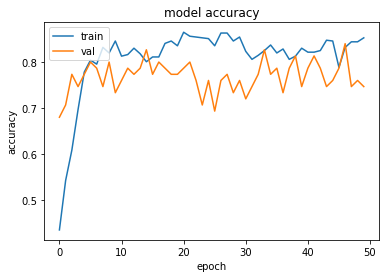

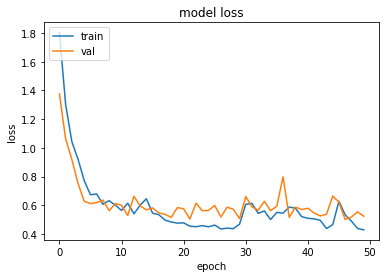

In [110]:
_=plt.figure(facecolor='white')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

_=plt.figure(facecolor='white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
print(f"{model.evaluate([test[:, 0:3, None], test[:, 3:, None]], test_y)}")

9/9 [==============================] - 0s 28ms/step - loss: 0.5483 - accuracy: 0.8546
[0.5482701063156128, 0.8546099662780762]


In [12]:
#show some predictions from test dataset
start = 40
predictions = 20
for n in range(start, start+predictions):
    print(f"\tPredicted: {np.argmax(model([test[None, n, 0:3, None], test[None, n, 3:, None]]), axis=1)}, expected: {np.argmax(test_y[n])}")

	Predicted: [1], expected: 1
	Predicted: [0], expected: 1
	Predicted: [2], expected: 2
	Predicted: [1], expected: 1
	Predicted: [1], expected: 1
	Predicted: [0], expected: 0
	Predicted: [1], expected: 1
	Predicted: [2], expected: 2
	Predicted: [0], expected: 0
	Predicted: [2], expected: 2
	Predicted: [1], expected: 1
	Predicted: [1], expected: 1
	Predicted: [2], expected: 1
	Predicted: [0], expected: 0
	Predicted: [0], expected: 0
	Predicted: [0], expected: 0
	Predicted: [2], expected: 2
	Predicted: [1], expected: 1
	Predicted: [1], expected: 1
	Predicted: [0], expected: 0


In [ ]:
for n, model in enumerate(models):
    model.save(f"models/classification_{modes[n]}.h5")